[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/regression/linear_regression.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Linear regression

In this notebook, we create a simple linear model using [scikit-learn](https://scikit-learn.org/). [scikit-learn](https://scikit-learn.org/) is a free and open-source machine learning library for the Python programming language. It features various classification, regression and clustering algorithms, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

We will use the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class that uses [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (OLS). OLS is an analytical method used to find the coefficients (parameters) that minimize the sum of the
squared differences (MSE) between the observed and predicted values.

OLS is computationally efficient for small to moderately sized datasets because it involves matrix operations. However, for very large datasets, OLS can become computationally expensive due to the need to compute the inverse of the X matrix. For such cases, Gradient Descent is a better approach.


In [6]:
# make sure the required packages are installed
%pip install numpy pandas scikit-learn matplotlib seaborn --quiet

repo='data-science-course'
module='regression'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/.  2>/dev/null
    !mv {repo}/{module}/data/* data/.  2>/dev/null

# import the required modules
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import utils

random_state = 42
np.random.seed(random_state)

Note: you may need to restart the kernel to use updated packages.


## Ground truth

The following function is what is unknown in regression problems, and we want to learn from data. In this example, we define it so that we can know how well our model is.

In [7]:
def ground_truth(x: float) -> float:
    """
    Ground truth function.
    :param x: input value (independent variable)
    :return: output value (dependent variable)
    """
    return -32.3 + 12.34 * x

## Data preparation

We create a dataset and split it into training and testing sets.

In [8]:
def create_dataset(n_samples: int, min_value: float, max_value: float) -> pd.DataFrame:
    """
    Creates a dataset with n_samples samples, taking x as random values of [min_value, max_value] and y as the ground truth
    :param n_samples: number of samples
    :param min_value: lower bound of the x values
    :param max_value: upper bound of the x values
    :return: a dataframe with the dataset (x and y columns)
    """
    # Create the random x values
    x = np.random.rand(n_samples) * (max_value - min_value) + min_value
    # Compute the y values from x
    y = np.vectorize(ground_truth)(x)
    # Add Gaussian noise to make prediction more difficult
    y += np.random.normal(0, (max_value - min_value), y.shape)
    # Returns a dataset
    return pd.DataFrame({'x': x, 'y': y})


# Create a dataset
data_set = create_dataset(1000, -10, 10)
print("First values on the dataset:", data_set.head(10), sep='\n')

First values on the dataset:
          x           y
0 -2.509198  -59.709479
1  9.014286   52.229404
2  4.639879   32.560062
3  1.973170    4.260629
4 -6.879627 -105.998791
5 -6.880110  -95.584938
6 -8.838328 -124.686521
7  7.323523   67.255874
8  2.022300   -8.748129
9  4.161452  -14.166906


Let's split the dataset into training and testing sets and visualize the training set.

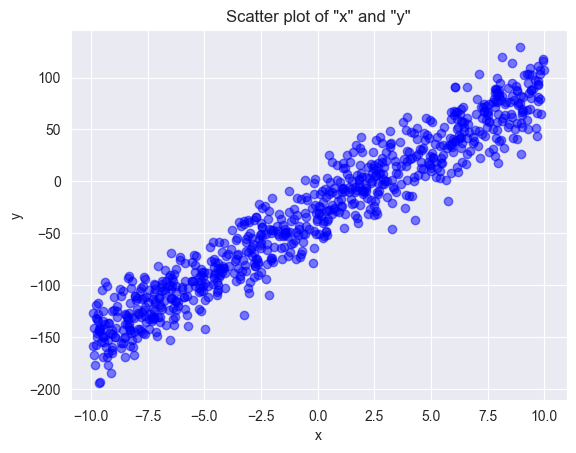

In [9]:
def split_dataset(dataset: pd.DataFrame, test_size: float = 0.2) -> (
        tuple)[tuple[pd.DataFrame, pd.DataFrame], tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Splits the dataset into training and testing sets
    :param dataset: the dataset to split
    :param test_size: the percentage of the dataset to use as testing
    :return: ((X_train, y_train), (X_test, y_test))
    """
    # Split the dataset into train and test sets
    train_data, test_data = train_test_split(dataset, test_size=test_size)
    # Separate independent and dependent variables (dependent variables must be created as matrices
    # (there could be multiple features)
    # We use [[]] for x because we want a DataFrame, not a Series (for y we want a Series)
    return (train_data[['x']], train_data['y']), (test_data[['x']], test_data['y'])


# Splits the dataset into training (X and y) and testing (X and y)
(X_train, y_train), (X_test, y_test) = split_dataset(data_set)

# Visualize the training set
utils.plot_values(X_train, y_train, 'x', 'y')

## Model creation and training

We create and train a `LinearRegression` model using the training dataset.

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Model evaluation

We evaluate the model with different metrics using the testing dataset.

We first predict the values of the test set.

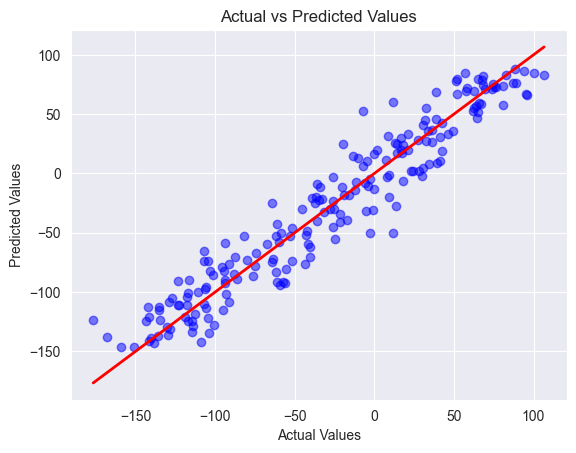

In [11]:
# Predict the values for the test set
y_pred = model.predict(X_test)
# Plots how well the model behaves
utils.plot_actual_vs_predicted_values(y_test, y_pred)

Let's compute the Mean Squared Error (MSE) for the test set.

In [12]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE) for the test set: {mse:.4f}.')

Mean Squared Error (MSE) for the test set: 394.1694.


MSE is an absolute value, hard to interpret. On the other hand, the coefficient of determination, denoted R2 or r2 or "R squared", is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). It ranges from -1 to 1. 0 means that the model does not explain any variability of the dependent value (it is the value returned for the average value uniform model). On the contrary, 1 represents that the model perfectly explains all the variability.

In [13]:
print(f"R-squared determination coefficient: {r2_score(y_test, y_pred):.4f}.")

R-squared determination coefficient: 0.9215.


## Model interpretation

Model interpretation is performed by analyzing the coefficients of the model. In this case, we only have one feature, so we only have one coefficient.

In [14]:
print(f"Learned parameters from data: Intercept = {model.intercept_:.4f}, Coefficient = {model.coef_[0]:.4f}.") 

Learned parameters from data: Intercept = -30.2989, Coefficient = 12.2124.


## ✨ Questions ✨

1. Do you think the model is computed correctly?
2. What is causing the R-squared not to be 1?
3. Can you fix it by modifying the code? Do it.
4. What happens now?

### Answers 

*Write your answers here.*

